Initial Dataset Shape: (194, 33)
Initial Dataset Sample:
              Crop  2004-05  2005-06  2006-07  2007-08  2008-09  2009-10  \
0            Rice    100.0    101.0     99.0    105.0    112.0    121.0   
1           Wheat    100.0    101.0    112.0    115.0    117.0    127.0   
2  Coarse Cereals    100.0    107.0    110.0    115.0    113.0    123.0   
3          Pulses    100.0    108.0    134.0    124.0    124.0    146.0   
4      Vegetables    100.0    109.0    103.0    118.0    113.0    124.0   

   2010-11  2011-12 State  ...  Area 2010-11  Yield 2006-07  Yield 2007-08  \
0    117.0    110.0   NaN  ...           NaN            NaN            NaN   
1    120.0    108.0   NaN  ...           NaN            NaN            NaN   
2    122.0    136.0   NaN  ...           NaN            NaN            NaN   
3    137.0    129.0   NaN  ...           NaN            NaN            NaN   
4    128.0    115.0   NaN  ...           NaN            NaN            NaN   

   Yield 2008-09  Yiel

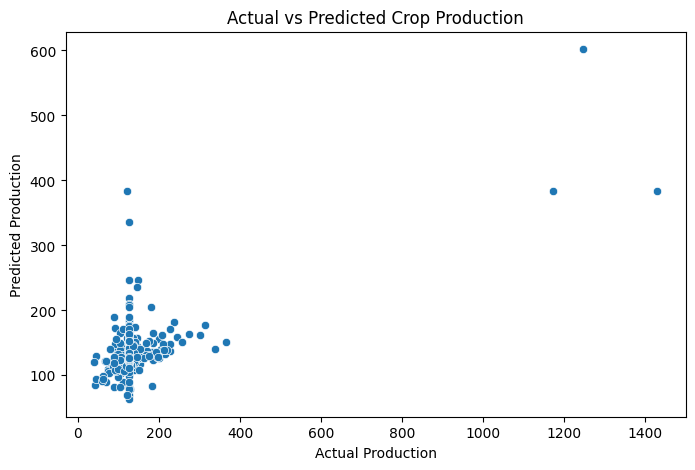

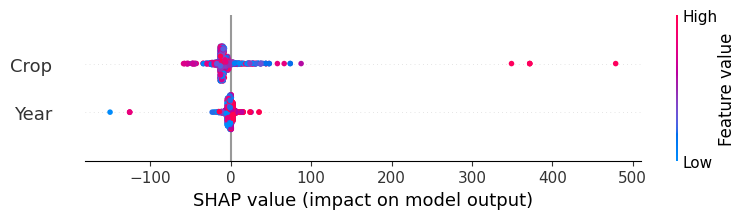

In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # SHAP for model interpretability
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Suppress warnings for clean output
warnings.filterwarnings("ignore", category=UserWarning, module="shap")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load all datasets from the 'datasets' folder
file_paths = ['datasets/dataset.csv', 'datasets/dataset1.csv', 'datasets/dataset2.csv', 'datasets/dataset3.csv']
df_list = [pd.read_csv(file) for file in file_paths]

# Combine all datasets
df = pd.concat(df_list, ignore_index=True)

# Debug: Show dataset structure before processing
print("Initial Dataset Shape:", df.shape)
print("Initial Dataset Sample:\n", df.head())

# Select relevant "Production" columns
valid_production_cols = [col for col in df.columns if "Production" in col or any(year in col for year in ['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011'])]

# Reshape dataset: Convert production year columns into rows (Long Format)
df_melted = df.melt(id_vars=['Crop'], value_vars=valid_production_cols, var_name='Year', value_name='Production')

# Convert "Year" to numeric safely
df_melted['Year'] = pd.to_numeric(df_melted['Year'].astype(str).str.extract(r'(\d{4})')[0], errors='coerce')

# Convert "Production" to numeric and fill missing values
df_melted['Production'] = pd.to_numeric(df_melted['Production'], errors='coerce')
df_melted['Production'].fillna(df_melted['Production'].median(), inplace=True)

# Drop rows with missing Year or Production
df_melted.dropna(subset=['Year', 'Production'], inplace=True)
df_melted['Year'] = df_melted['Year'].astype(int)

# Debug: Show dataset after cleaning
print("After Cleaning Shape:", df_melted.shape)
print("After Cleaning Sample:\n", df_melted.head())

# Check if dataset is empty after preprocessing
if df_melted.empty:
    raise ValueError("Dataset is empty after preprocessing! Check original CSV files.")

# Encode categorical variable 'Crop'
le = LabelEncoder()
df_melted['Crop'] = le.fit_transform(df_melted['Crop'])

# Split dataset into training and testing sets
X = df_melted[['Crop', 'Year']]
y = df_melted['Production']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure X_train is numeric before passing to SHAP
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Train a RandomForest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Model Performance: R2 Score = {r2:.3f}, MAE = {mae:.3f}, MSE = {mse:.3f}")

# Plot actual vs predicted values
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Production")
plt.ylabel("Predicted Production")
plt.title("Actual vs Predicted Crop Production")
plt.show()

# SHAP Values for Model Interpretability
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Ensure SHAP works even if X_test is small
if len(X_test) > 1:
    shap.summary_plot(shap_values, X_test)
else:
    print("Skipping SHAP plot due to small test dataset.")


In [29]:
# Load the dataset
df = pd.read_csv('datasets/dataset.csv')

In [30]:
# Display basic info about the dataset
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Crop     12 non-null     object
 1   2004-05  12 non-null     int64 
 2   2005-06  12 non-null     int64 
 3   2006-07  12 non-null     int64 
 4   2007-08  12 non-null     int64 
 5   2008-09  12 non-null     int64 
 6   2009-10  12 non-null     int64 
 7   2010-11  12 non-null     int64 
 8   2011-12  12 non-null     int64 
dtypes: int64(8), object(1)
memory usage: 996.0+ bytes
None
       2004-05    2005-06     2006-07     2007-08     2008-09     2009-10  \
count     12.0   12.00000   12.000000   12.000000   12.000000   12.000000   
mean     100.0   99.75000  102.000000  104.750000  106.416667  114.916667   
std        0.0    6.64865   12.634728   10.963783   11.261022   15.900019   
min      100.0   86.00000   85.000000   87.000000   80.000000   81.000000   
25%      100.0   96.75000   96.250000   97.750

In [31]:
# Handle missing values using KNN Imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df.iloc[:, 1:] = imputer.fit_transform(df.iloc[:, 1:])


In [32]:

# Convert categorical variables into numerical format
df = pd.get_dummies(df, drop_first=True)

# Ensure all columns contain only numeric values
df = df.apply(pd.to_numeric, errors='coerce')


In [33]:
# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with column means
df.fillna(df.mean(), inplace=True)


In [34]:
# Feature Selection using Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]

# Compute VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = df_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])]

print(vif_data)

   Feature         VIF
0  2004-05  635.925335
1  2005-06    6.746275
2  2006-07    5.418232
3  2007-08   25.183043
4  2008-09   14.088861
5  2009-10   16.518640
6  2010-11    4.592106
7  2011-12    3.316104


In [35]:
# Define features (X) and target (y)
X = df.drop(columns=['Crop_Rice'])  # Replace 'Crop_Production' with your actual target column
y = df['Crop_Rice']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

# Ensure there are no missing values
X = X.fillna(X.mean())  
y = y.fillna(y.mean())

# Train-test split with sufficient data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure the dataset is large enough
if X_train.shape[0] < 2:
    raise ValueError("Not enough training samples. Increase dataset size or adjust test_size.")

# Define models and hyperparameters
models = {
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}

param_grid = {
    'RandomForest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.01]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.01]}
}

best_model = None
best_score = -np.inf

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=2, scoring='r2', error_score='raise')
    
    try:
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.best_estimator_.predict(X_test)
        
        if len(y_test) < 2:  # Prevent R^2 error
            print(f"Skipping R2 score for {name} due to insufficient test samples.")
            continue
        
        score = r2_score(y_test, y_pred)
        
        print(f'{name} Best Params: {grid_search.best_params_}')
        print(f'{name} R2 Score: {score}\n')
        
        if score > best_score:
            best_score = score
            best_model = grid_search.best_estimator_

    except Exception as e:
        print(f"Error training {name}: {e}")

print(f"Best Model: {best_model}")


RandomForest Best Params: {'max_depth': 10, 'n_estimators': 100}
RandomForest R2 Score: -0.4999999999999998

GradientBoosting Best Params: {'learning_rate': 0.1, 'n_estimators': 100}
GradientBoosting R2 Score: -0.4999999999999998

XGBoost Best Params: {'learning_rate': 0.1, 'n_estimators': 100}
XGBoost R2 Score: -0.5000001192092896

Best Model: RandomForestRegressor(max_depth=10)


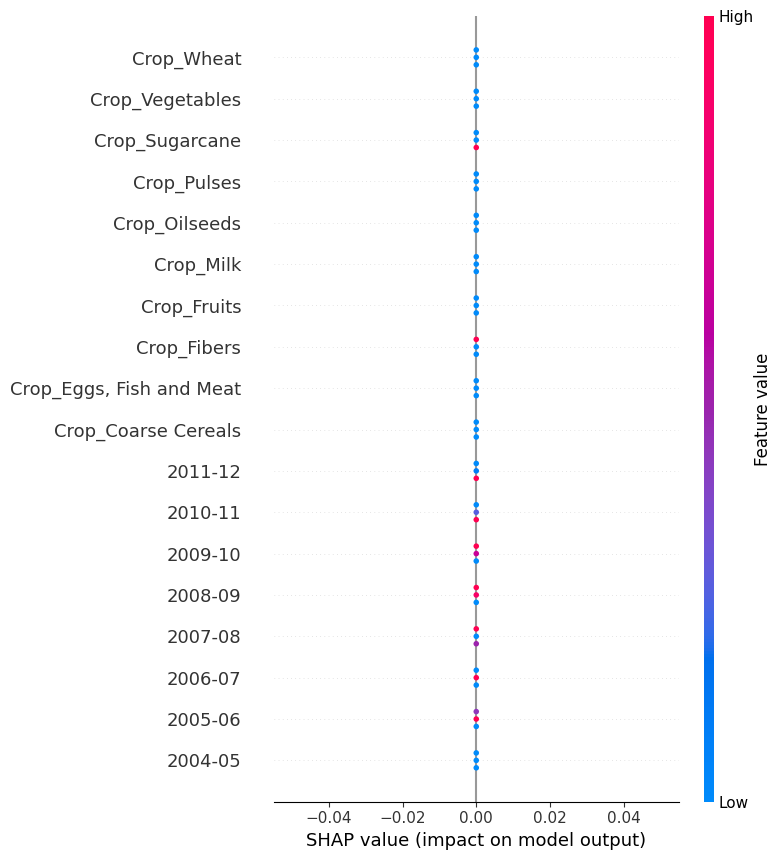

In [40]:
import shap

# Ensure X_test is numeric before passing to SHAP
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Use TreeExplainer for RandomForest and XGBoost models
if isinstance(best_model, (RandomForestRegressor, XGBRegressor)):
    explainer = shap.TreeExplainer(best_model)
else:
    explainer = shap.Explainer(best_model, X_test)

# Compute SHAP values
shap_values = explainer(X_test)

# SHAP Summary Plot with Custom Settings
shap.summary_plot(shap_values, X_test, plot_type="dot", show=True)
